This file is to select lr based on the loss curve

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import time
from pathlib import Path    
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tqdm import trange, tqdm
plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
from models.model_utils import generate_position_encode, load_model_class, trans_batch, eval_model
from data_utils.eeg_load_sz import EEGDataSZ
from data_utils import convert_to_type, get_triple, digitize_data, rec_data, MyDataLoader
from utils.misc import delta_time, load_pkl_folder2dict, save_pkl_dict2folder

In [6]:
# pkgs for pytorch (on Apr 3, 2023)
import torch
import torch.nn as nn

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.set_default_device(device)
print(device)

cuda


# Load data and model

## Load model

In [9]:

def _load_losses(model_path):
    if isinstance(model_path, str):
        model_path = Path(model_path);
    model_utils = load_pkl_folder2dict(model_path, including=["*_params*", "loss_save*"], verbose=0);
    return  model_utils

In [17]:
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
cepoch = 7
all_models = []
for lr in lrs:
    name = f"RAWINPUT_aux_lossTrue_lr{lr*1000000:.0f}_lr_gamma10_ntrain_batch0_aux_loss_weight100_epoch{cepoch}_iter3691"
    all_models.append(_load_losses(RES_ROOT/name))

In [18]:
all_models[0].loss_save.keys()

dict_keys(['train', 'val', 'test'])

# Analysis 

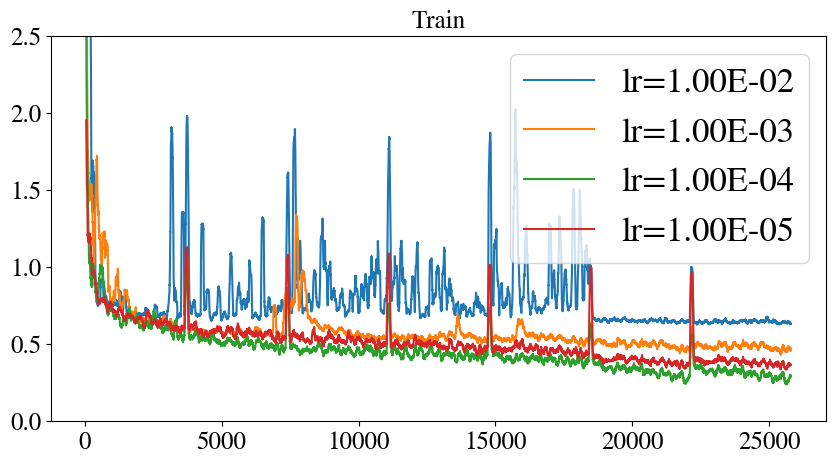

In [44]:
from copy import deepcopy

window = 100
def move_average(vec, window=100):
    vec = np.convolve(vec, np.ones(window)/window, mode="valid")
    return vec

#plt.subplot(121)
plt.title("Train")
for lr, model in zip(lrs, all_models):
    plt.plot(move_average(model.loss_save["train"]["niter"], window=window), 
             move_average(model.loss_save["train"]["cls_loss"], window=window), 
             label=f"lr={lr:.2E}")
plt.ylim(0., 2.5)
plt.legend()

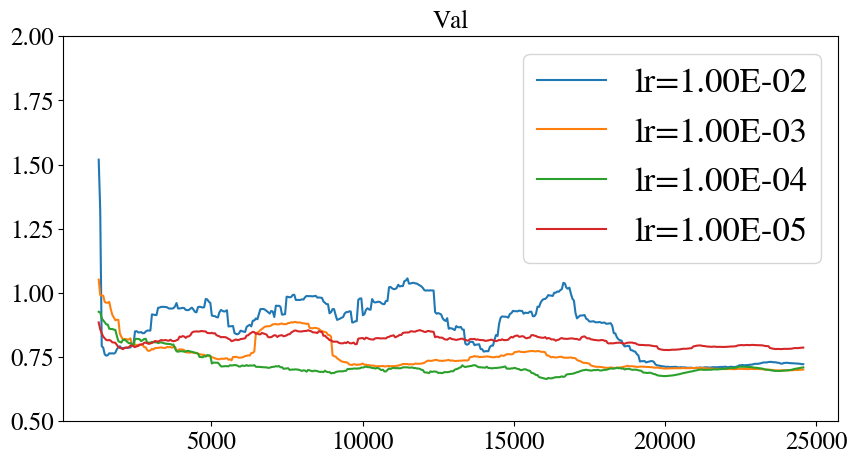

In [38]:
window = 50
plt.title("Val")
for lr, model in zip(lrs, all_models):
    plt.plot(move_average(model.loss_save["val"]["niter"], window=window), 
             move_average(model.loss_save["val"]["loss_cls"], window=window), 
             label=f"lr={lr:.2E}")
plt.ylim(0.5, 2)
plt.legend()

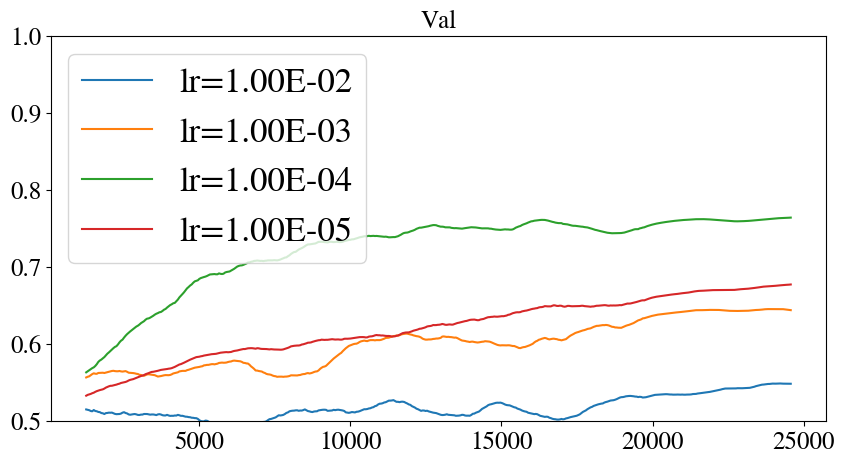

In [36]:
window = 50
plt.title("Val")
for lr, model in zip(lrs, all_models):
    plt.plot(move_average(model.loss_save["val"]["niter"], window=window), 
             move_average(model.loss_save["val"]["auc"], window=window), 
             label=f"lr={lr:.2E}")
plt.ylim(0.5, 1)
plt.legend()